In [9]:
import sys
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

print(sys.version)

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [53]:
MAIN_COLOR_1 = "#7D92C3"
MAIN_COLOR_2 = "#4664AA"
ACCENT_COLOR = "#902020"

RUN = "writtenwork_depth"
CLASSES = ["Comic"]

RES_PATH = f"out/_results_{RUN}.csv"

res = pd.read_csv(RES_PATH, index_col=0)

print(res)

                              m  connected  bipartite      n_t     n_b  \
WrittenWork           1430486.0      False       True  90862.0  6235.0   
Comic                  123468.0       True       True   6688.0   996.0   
Manga                   81038.0       True       True   3783.0   459.0   
PeriodicalLiterature   368326.0      False       True  22235.0  1743.0   
AcademicJournal        174820.0      False       True   7688.0   561.0   
Magazine               102287.0       True       True   6728.0  1011.0   
Newspaper               97900.0      False       True   8060.0   958.0   

                       density        k_t         k_b           m_t   n_t_om  \
WrittenWork           0.002525  15.743501  229.428388  2.887892e+09  90862.0   
Comic                 0.018535  18.461124  123.963855  2.005113e+07   6688.0   
Manga                 0.046670  21.421623  176.553377  7.022957e+06   3783.0   
PeriodicalLiterature  0.009504  16.565145  211.317269  2.134585e+08  22235.0   
Academi

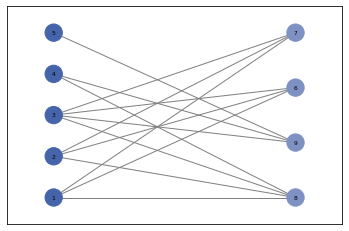

In [54]:
G = nx.Graph()
G.add_edges_from([(1,6),(1,7),(1,8),(2,6),(2,7),(2,8),(3,6),(3,7),(3,8),(3,9),(4,8),(4,9),(5,9)])

coloring = nx.greedy_color(G, strategy="largest_first")
nodecolors = []
for node in G.nodes():
    if coloring[node] == 0:
        nodecolors.append(MAIN_COLOR_1)
    else:
        nodecolors.append(MAIN_COLOR_2)

top = nx.bipartite.sets(G)[0]
bi_layout = nx.bipartite_layout(G, top, aspect_ratio=0.5, scale=0.2)
nx.draw_networkx(G, bi_layout, with_labels=True, font_size=6,node_color=nodecolors, edge_color="grey")


13269 nodes with degree >= 1 and 0.0 disconnected nodes


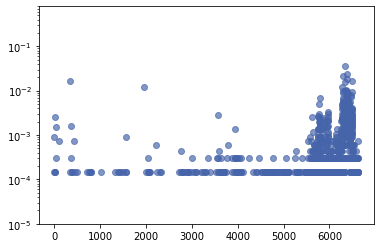

In [55]:
with open(f"out/{CLASSES[0]}.t.k.json", "r") as input_file:
    dist = json.load(input_file)

nnodes = 0
for key, value in dist.items():
    nnodes += value

n_t = res.loc[CLASSES[0], "n_t"]
ndiscnodes = n_t - nnodes

x = []
y = []
for key, value in dist.items():
    x.append(int(key))
    y.append(float(value / nnodes))
    
print(f"{sum} nodes with degree >= 1 and {ndiscnodes} disconnected nodes")
x.append(0)
y.append(float(ndiscnodes / nnodes))

# plt.xscale("log")
# plt.xlim(0.1, 800000)
plt.yscale("log")
plt.ylim(0.00001, 0.8)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

996 nodes with degree >= 1 and 0.0 disconnected nodes


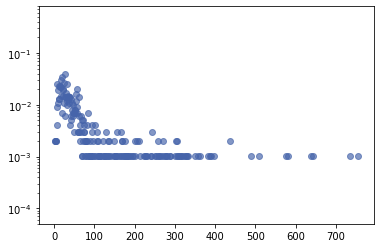

In [56]:
with open(f"out/{CLASSES[0]}.b.k.json", "r") as input_file:
    dist = json.load(input_file)

nnodes = 0
for key, value in dist.items():
    nnodes += value

n_b = res.loc[CLASSES[0], "n_b"]
ndiscnodes = n_b - nnodes

x = []
y = []
for key, value in dist.items():
    x.append(int(key))
    y.append(float(value / nnodes))
    
print(f"{nnodes} nodes with degree >= 1 and {ndiscnodes} disconnected nodes")
x.append(0)
y.append(float(ndiscnodes / nnodes))

# plt.xscale("log")
# plt.xlim(0.5, 50000)
plt.yscale("log")
plt.ylim(0.00005, 0.8)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

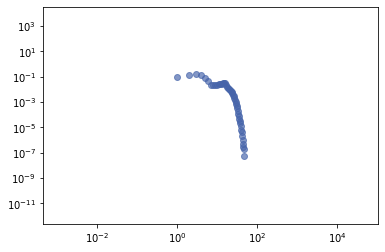

In [57]:
with open(f"out/{CLASSES[0]}.t.w.json", "r") as input_file:
    dist = json.load(input_file)

nnodes = 0
for key, value in dist.items():
    if int(key) > 0:
        nnodes += value

x = []
y = []
for key, value in dist.items():
    if int(key) > 0:
        x.append(int(key))
        y.append(float(value / nnodes))

plt.xscale("log")
# plt.xlim(0.5, 500)
plt.yscale("log")
# plt.ylim(0.000000000001, 0.5)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

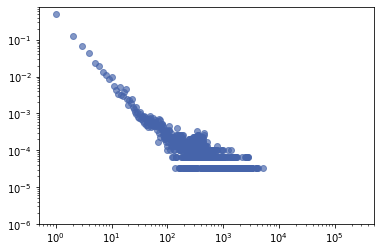

In [58]:
with open(f"out/{CLASSES[0]}.b.w.json", "r") as input_file:
    dist = json.load(input_file)

sum = 0
for key, value in dist.items():
    if int(key) > 0:
        sum += value

x = []
y = []
for key, value in dist.items():
    if int(key) > 0:
        x.append(int(key))
        y.append(float(value / sum))

plt.xscale("log")
plt.xlim(0.5, 500000)
plt.yscale("log")
plt.ylim(0.000001, 0.8)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

<BarContainer object of 996 artists>

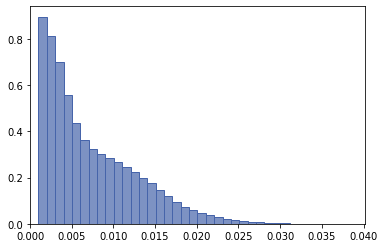

In [68]:
df = pd.read_csv(f"out/{CLASSES[0]}.t.knc.csv")

n_t = res.loc[CLASSES[0], "n_t"]
n_b = res.loc[CLASSES[0], "n_b"]
k_max_t = n_b
w_max_t = 40

knc_density = df["density"]
knc_ncomponents = (n_t - df["ncomponents"]) / (n_t - 1)
knc_slcc = (df["slcc"] - 1) / (n_t -1)

plt.xlim(0, w_max_t/k_max_t)
plt.bar(df["k"]/k_max_t, knc_density, width=1/k_max_t, align="edge", color=MAIN_COLOR_1, edgecolor=MAIN_COLOR_2)


In [ ]:
df = pd.read_csv(f"out/{CLASSES[0]}.b.knc.csv")

n_t = res.loc[CLASSES[0], "n_t"]
n_b = res.loc[CLASSES[0], "n_b"]
k_max_b = n_t
w_max_b = 200

knc_density = df["density"]
knc_ncomponents = (n_b - df["ncomponents"]) / (n_b - 1)
knc_slcc = (df["slcc"] - 1) / (n_b -1)

plt.xlim(0, w_max_b/k_max_b)
plt.bar(df["k"]/k_max_b, knc_ncomponents, width=1/k_max_b, align="edge", color=MAIN_COLOR_1, edgecolor=MAIN_COLOR_2)
